# RNN

In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph
sess = tf.Session()

In [2]:
# Set RNN parameters
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [7]:
data_file = './dataset/text_data.txt'

In [8]:
text_data = []
with open(os.path.join(data_file), 'r') as file_conn:
    for row in file_conn:
        text_data.append(row)
text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [15]:
text_data[0][0]

'ham'

In [16]:
text_data[0][1]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'

In [17]:
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


text_data_train = [clean_text(x) for x in text_data_train]

vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [18]:
vocab_processor

In [19]:
text_processed

array([[ 44, 455,   0, ...,   0,   0,   0],
       [ 47, 315,   0, ...,   0,   0,   0],
       [ 46, 465,   9, ...,   0, 368,   0],
       ...,
       [  0,  59,   9, ...,   0,   0,   0],
       [  5, 493, 108, ...,   1, 198,  12],
       [  0,  40, 474, ...,   0,   0,   0]], dtype=int64)

In [20]:
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [21]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

# Define the RNN cell
# tensorflow change >= 1.0, rnn is put into tensorflow.contrib directory. Prior version not test.
if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [24]:
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.61, Test Acc: 0.82
Epoch: 2, Test Loss: 0.59, Test Acc: 0.82
Epoch: 3, Test Loss: 0.56, Test Acc: 0.82
Epoch: 4, Test Loss: 0.53, Test Acc: 0.82
Epoch: 5, Test Loss: 0.5, Test Acc: 0.83
Epoch: 6, Test Loss: 0.47, Test Acc: 0.83
Epoch: 7, Test Loss: 0.45, Test Acc: 0.83
Epoch: 8, Test Loss: 0.44, Test Acc: 0.84
Epoch: 9, Test Loss: 0.43, Test Acc: 0.84
Epoch: 10, Test Loss: 0.42, Test Acc: 0.84
Epoch: 11, Test Loss: 0.42, Test Acc: 0.84
Epoch: 12, Test Loss: 0.42, Test Acc: 0.85
Epoch: 13, Test Loss: 0.42, Test Acc: 0.85
Epoch: 14, Test Loss: 0.41, Test Acc: 0.85
Epoch: 15, Test Loss: 0.41, Test Acc: 0.86
Epoch: 16, Test Loss: 0.41, Test Acc: 0.86
Epoch: 17, Test Loss: 0.41, Test Acc: 0.86
Epoch: 18, Test Loss: 0.4, Test Acc: 0.86
Epoch: 19, Test Loss: 0.4, Test Acc: 0.86
Epoch: 20, Test Loss: 0.4, Test Acc: 0.86


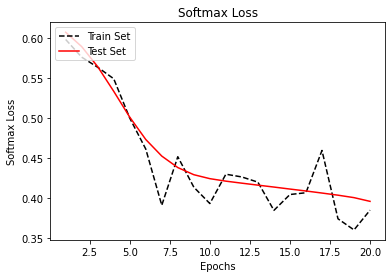

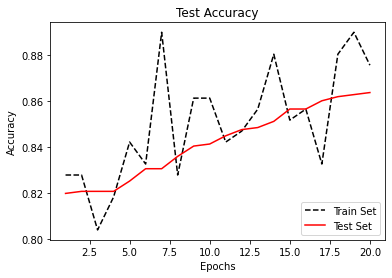

In [25]:
%matplotlib inline

# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()